<a href="https://colab.research.google.com/github/jeffrey96158/Vertical-Federated-Learning-without-explicit-ID-Matching/blob/main/Vertical_Federated_Learning_without_Explicit_ID_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phe
!pip install cupy-cuda100
!pip install lshashpy3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61.3 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-py3-none-any.whl size=8903 sha256=f84ea296673084874f19f844eea02d052a2dc5f090368de86b5c0bbf8bcfce18
  Stored in directory: /root/.cache/pip/wheels/ea/6c/32/738c5ecef6675bcadb576e2f0c8d076d606b0101b646816c43
Successfully built lshashpy3


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
# pytorch
from torch.utils.data import Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data
# others
from tqdm.notebook import tqdm as tqdm
import argparse
from sklearn.metrics import f1_score
from sklearn import preprocessing
import random

import matplotlib.pyplot as plt
import numpy as np
#import cupy as cp
import pandas as pd



# Download Dataset from my Google drive



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Sensorless_drive_diagnosis.txt', sep = " ", header = None)
df = df.sample(frac=1).reset_index(drop=True)
# data with (58509 instances) * (48 features + 1 answer)

# the class should between 0 - 10
df.iloc[:, -1] = df.iloc[:, -1].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


# split data into 8:1:1 for training, testing and validating
# pick 57000 data, train: 45000, test: 6000 validation: 6000
test_set = df.iloc[:6000, 0:49]
valid_set = df.iloc[6000: 12000, 0:49]
train_set = df.iloc[12000: 57000, 0:49]





Mounted at /content/gdrive


# Argument

In [ ]:
parser = argparse.ArgumentParser(description='VFL with PyTorch')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=50, metavar='S',
                    help='random seed (default: 50)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 1)')
parser.add_argument('--lr', type=float, default=1e-05, metavar='LR',
                    help='learning rate (default: 1e-5)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--batch-size', type=int, default=50, metavar='N',
                    help='input batch size for training (default: 50)')
parser.add_argument('--test-batch-size', type=int, default=50, metavar='N',
                    help='input batch size for testing (default: 50)')
parser.add_argument('--num-participants', type=int, default=12, metavar='NP',
                    help='number of participants (default: 12)')
parser.add_argument('--randomorder_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Random Order (default: 1)')
parser.add_argument('--asynchronous_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Asynchronous (default: 1)')
args = parser.parse_args(args=[])

#Class Defination

In [ ]:
## Initialization
# Control Seed
# CUDA is a GPU core for parrallel computing
torch.manual_seed(args.seed)

# Select Device
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

if use_cuda:
    print("Using CUDA!")
    torch.cuda.manual_seed(args.seed)
else:
    print('Not using CUDA!!!')

# transform panda's dataframe into pytorch tensor
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

Using CUDA!


# Linkage Process

In [ ]:
from lshashpy3 import LSHash
# Linkage Process (PPRL)
# 對dataset進行linkage和處理
def Linkage_Process(data_set, common_num, overlap, K):
  bound = (1 - overlap) / 2
  col = int(common_num / 2)
  lsh = LSHash(6, 2 * col)
  table = dict()

  row = int(data_set.shape[0] * bound)

  Party_A_dataset = np.zeros((int(data_set.shape[0] * (1- bound)), K ,24 + col + 1),dtype = np.double)
  Party_B_dataset = np.zeros((int(data_set.shape[0] * (1- bound)), K ,24 + col + 1),dtype = np.double)

  # put B into index, use table to store the value
  for idx in tqdm(range(row, data_set.shape[0])):
    [f] = data_set.iloc[idx:idx+1, 24-col:24+col].values.tolist()
    hash_val = hash(str(f))
    table[hash_val] = idx
    lsh.index(f)
  # a row
  row = int(data_set.shape[0] * (1-bound))
  top_k = K
  dist = [[float(0) for c in range(top_k)] for r in range(row)]
  raw_similarity = [[float(0) for c in range(top_k)] for r in range(row)]
  similarity = [[float(0) for c in range(top_k)] for r in range(row)]

  # put A into query and get the kth nearest neighbor
  for idx in tqdm(range(0, row)):
    [data_in_a] = data_set.iloc[idx:idx+1, 24-col:24+col].values.tolist()
    nn = lsh.query(data_in_a, num_results = top_k, distance_func = "euclidean")
    k = 0
    for ((vec, extra_data), distance) in nn:
      hash_val = hash(str(list(vec)))
      dist[idx][k] = distance
      B_id = table[hash_val]
      Party_A_dataset[idx, k, :-1] = data_set.iloc[idx:idx+1,:24+col]
      Party_B_dataset[idx, k] = data_set.iloc[B_id:B_id+1,24-col:]
      Party_A_dataset[idx, k, 24 + col:] = data_set.iloc[idx:idx+1, 48:]
      k+=1

  # get the normalized the distance
  dist_np = np.array(dist)
  normal_dist = dist_np / np.linalg.norm(dist_np)

  # get the original similarity
  normal_dist = -1 * normal_dist
  shape = normal_dist.shape

  # add noise to the original similarity.
  noise = np.random.normal(loc = 0, scale = 1e-6, size = shape)
  similarity = normal_dist + noise
  sim = np.array(similarity)

  datas = Party_A_dataset[:,:,0:28]
  ans = Party_A_dataset[:,:,28]
  PA_dataset = TensorDataset(torch.FloatTensor(datas),torch.FloatTensor(ans))

  datas = Party_B_dataset[:,:,0:28]
  ans = Party_B_dataset[:,:,28]
  PB_dataset = TensorDataset(torch.FloatTensor(datas),torch.FloatTensor(ans))

  Sim_dataset = TensorDataset(torch.FloatTensor(sim),torch.FloatTensor(ans))

  return Sim_dataset, PA_dataset, PB_dataset

# debug
# common_num = 8
# overlap = 1.0
# top_k = 3
# similarities, Party_A, Party_B = Linkage_Process(test_set, common_num, overlap, top_k)
# print(f'Party A is {Party_A[0:3]}')
# print(f'Party B is {Party_B[0:3]}')
# print(f'Sim is {similarities[0:3]}')

# Split data

In [ ]:
from torch.utils.data.dataset import TensorDataset

import statistics

#common_num common feature的數量(要是2的倍數)
#overlap 整個dataset中有多少比例的Row是overlap的
def Two_Party_SplitData(train_set, test_set, valid_set, common_num, overlap):
  top_k = 3
  p_num = 2
  if((48 - common_num)) % 2 != 0:
    return 0
  split_train_set = [list()] * p_num
  split_test_set = [list()] * p_num
  split_valid_set = [list()] * p_num
  # 根據participants數量將train set和test set切成n等分

  sim_train_set, Party_A, Party_B = Linkage_Process(train_set, common_num, overlap, top_k)
  split_train_set[0] = Party_A
  split_train_set[1] = Party_B

  #Split test_set
  sim_test_set, Party_A, Party_B = Linkage_Process(test_set, common_num, overlap, top_k)
  split_test_set[0] = Party_A
  split_test_set[1] = Party_B

  #Split valid_set
  sim_valid_set, Party_A, Party_B = Linkage_Process(valid_set, common_num, overlap, top_k)
  split_valid_set[0] = Party_A
  split_valid_set[1] = Party_B

  TrainDataSet_dict = dict()
  TestDataSet_dict = dict()
  ValidDataSet_dict = dict()
  for i in range(p_num):
    p = 'P'
    p = p + str(i)
    TrainDataSet_dict[p] = data.DataLoader(dataset = split_train_set[i], batch_size = args.batch_size, shuffle=False, num_workers = 0)
    TestDataSet_dict[p] = data.DataLoader(dataset = split_test_set[i], batch_size = args.batch_size, shuffle=False, num_workers = 0)
    ValidDataSet_dict[p] = data.DataLoader(dataset = split_valid_set[i], batch_size = args.batch_size, shuffle=False, num_workers = 0)

  TrainDataSet_dict["Similarity"] = data.DataLoader(dataset = sim_train_set, batch_size = args.batch_size, shuffle=False, num_workers = 0)
  TestDataSet_dict["Similarity"] = data.DataLoader(dataset = sim_test_set, batch_size = args.batch_size, shuffle=False, num_workers = 0)
  ValidDataSet_dict["Similarity"] = data.DataLoader(dataset = sim_valid_set, batch_size = args.batch_size, shuffle=False, num_workers = 0)
  return TrainDataSet_dict, TestDataSet_dict, ValidDataSet_dict



# Training model

In [ ]:
class weight_gate_net(nn.Module):
  def __init__(self):
    super(weight_gate_net,self).__init__()
    self.W1 = nn.Linear(3,20).double()
    self.W2 = nn.Linear(20,20).double()
    self.W3 = nn.Linear(20,3).double()
    self.set_init(self.W1)
    self.set_init(self.W2)
    self.set_init(self.W3)
  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)
  def forward(self, x):
    x = self.W1(x)
    x = self.W2(x)
    x = self.W3(x)
    return x

class merge_gate_net(nn.Module):
  def __init__(self):
    super(merge_gate_net,self).__init__()
    # Convolution 1, input shape = ()
    # input_size= (50 * 1 * 3 * 20)
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size= (1,2))
    self.drop = nn.Dropout(p = 0.5)
    self.relu = nn.ReLU(inplace = True)

    # size = (50 * 1 * 3 * 19)
    self.maxpool1 = nn.MaxPool2d(kernel_size = (1,2), stride = 1)

    # size = (50 * 1 * 3 * 18)
    self.cnn2 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size= (1,2))

    # size = (50 * 1 * 3 * 17)
    self.maxpool2 = nn.MaxPool2d(kernel_size = (1,2), stride = 1)

    # size = (50 * 1 * 3 * 16)
    self.fc1 = nn.Linear(3 * 16, 50)
    self.fc2 = nn.Linear(50,11)

    self.set_init(self.cnn1)
    self.set_init(self.cnn2)
    self.set_init(self.fc1)
    self.set_init(self.fc2)

  def set_init(self,layer):
    torch.nn.init.kaiming_uniform_(layer.weight)
    torch.nn.init.constant_(layer.bias,0)

  def forward(self,x):
    x = x.type(torch.cuda.FloatTensor)
    x = self.cnn1(x)
    x = self.maxpool1(x)
    x = self.relu(x)
    x = self.cnn2(x)
    x = self.maxpool2(x)
    x = self.relu(x)

    x = x.reshape(50,48)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

class Party_A_network(nn.Module):
  def __init__(self):
    super(Party_A_network,self).__init__()
    self.L1 = nn.Linear(28,50).double()
    self.L2 = nn.Linear(50,50).double()
    self.L3 = nn.Linear(50,15).double()
    #self.L1B = nn.BatchNorm1d(15,dtype=torch.float64)
    self.set_init(self.L1)
    self.set_init(self.L2)
    self.set_init(self.L3)


  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)

  def forward(self,x):
    x = self.L1(x)
    x = F.relu(x)
    x = self.L2(x)
    x = F.relu(x)
    x = self.L3(x)
    x = F.relu(x)
    return x

class Aggregate_network(nn.Module):
  def __init__(self):
    super(Aggregate_network,self).__init__()
    self.L1 = nn.Linear(15 * 2, 50).double()
    self.L2 = nn.Linear(50,50).double()
    self.output = nn.Linear(50,20).double()

    self.set_init(self.L1)
    self.set_init(self.L2)

  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)

  def forward(self, x):
    x = self.L1(x)
    x = F.relu(x)
    x = self.L2(x)
    x = F.relu(x)
    x = self.output(x)
    return x
class test_network(nn.Module):
  def __init__(self):
    super(test_network,self).__init__()
    self.L1 = nn.Linear(15 * 2, 50).double()
    self.L2 = nn.Linear(50,50).double()
    self.output = nn.Linear(50,11).double()

    self.set_init(self.L1)
    self.set_init(self.L2)

  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)

  def forward(self, x):
    x = self.L1(x)
    x = F.relu(x)
    x = self.L2(x)
    x = F.relu(x)
    x = self.output(x)
    return x
class Party_A_class():
  def __init__(self):
    global device
    self.network = Party_A_network().to(device)
    self.aggregate_network = Aggregate_network().to(device)

  def LocalTrain(self,data):
    return self.network(data)
class Party_B_class():
  def __init__(self):
    global device
    self.network = Party_A_network().to(device)
  def LocalTrain(self,data):
    return self.network(data)

class Server_class():
  def __init__(self,Party_A,Party_B):
    global device
    self.merge_gate = merge_gate_net().to(device)
    self.weight_gate = weight_gate_net().to(device)
    self.test_net = test_network().to(device)
    self.lr = args.lr
    #merge gate params
    para = list(self.merge_gate.parameters())
    #aggregate params
    para = para + list(Party_A.aggregate_network.parameters())
    #weight gate params
    para = para + list(self.weight_gate.parameters())
    #party a params
    para = para + list(Party_A.network.parameters())
    #party b params
    para = para + list(Party_B.network.parameters())

    #self.optimizer = torch.optim.Adagrad(params=para, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
    self.optimizer = torch.optim.Adam(params=para , lr = self.lr, eps=1e-7)
    self.loss_fn = nn.CrossEntropyLoss()

  def Sort_Gate(self,weight,mid_output):
    weight_diag = torch.diag_embed(weight,dim1 = 1)
    ans = torch.bmm(weight_diag,mid_output)
    return ans
  def ansProcess(self,ans):
    answer = torch.zeros([50], dtype=torch.float64)
    for i in range(50):
      answer[i] = ans[i][0]
    return answer

# Vertical Train

In [ ]:
def similarities_explot_vertical_train(Party_A,Party_B,Server,train_data,epochs):
  print(f'2 participants training with {epochs} epochs')
  loss_history = list()
  accu_history = []
  testloss_history = []
  f1_history = []
  p_num = 2
  for e in tqdm(range(epochs)):
    correct = 0
    total_loss = 0
    Labels = []
    Predicts = []
    k = 0
    #for i in range(len(train_data['P0'])):
    for i, pack in enumerate(zip(train_data['P0'], train_data['P1'],train_data['Similarity'])):
      it = [0 for x in range(p_num)]
      data = [0 for x in range(p_num)]
      ans = [0 for x in range(p_num)]

      #Party's data next iteration
      data[0],ans[0] = pack[0]
      data[1],ans[1] = pack[1]
      sim_data,a = pack[2]

      data[0],ans[0] = data[0].double(), ans[0].double()
      data[1],ans[1] = data[1].double(), ans[1].double()
      sim_data,a = sim_data.double(), a.double()

      data[0],ans[0] = data[0].to(device), ans[0].to(device)
      data[1],ans[1] = data[1].to(device), ans[1].to(device)
      sim_data,a = sim_data.to(device), a.to(device)

      #Two Party forward training
      Party_A_out = Party_A.network(data[0])
      Party_B_out = Party_B.network(data[1])

      #Concat the output of Party's training
      Party_concat_out = torch.cat((Party_A_out,Party_B_out),-1)

      #Party Aggregate training
      Party_Aggregate_out = Party_A.aggregate_network(Party_concat_out)

      #Weight Gate
      weight = Server.weight_gate(sim_data)

      #Sort Gate
      sorted_out = Server.Sort_Gate(weight,Party_Aggregate_out)
      sorted_out = sorted_out.view(50,1,3,20)

      #Merge Gate
      predict_ans = Server.merge_gate(sorted_out)

      #Loss function
      answer = Server.ansProcess(ans[0])
      answer = answer.to(device)
      server_loss = Server.loss_fn(predict_ans, answer.long())

      #backward
      Server.optimizer.zero_grad()
      server_loss.backward()
      Server.optimizer.step()

      loss_history.append(server_loss.cpu().detach().numpy())
      total_loss += server_loss.cpu().detach().numpy()

      predict = predict_ans.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
      correct += predict.eq(answer.data.view_as(predict)).sum().item()
      Labels = Labels + answer.tolist()
      Predicts = Predicts + predict.tolist()

    total_loss /= len(train_data['P0'])
    accuracy = 100. * correct / (len(train_data['P0']) * 50)
    f1 = f1_score(Labels, Predicts, average = "macro")

    if e >= 700 and accuracy < 15:
          return [], [], []

    testloss_history.append(total_loss)
    accu_history.append(accuracy / 100)
    f1_history.append(f1)

  return testloss_history, accu_history, f1_history

#Vertical test

In [ ]:
def vertical_test(Party_A,Party_B,Server,test_data):
  p_num = 2
  loss_history = list()
  total_loss = 0
  correct = 0
  Labels = []
  Predicts = []
  accu_history = []
  testloss_history = []
  f1_history = []

  for i, pack in enumerate(zip(test_data['P0'], test_data['P1'],test_data['Similarity'])):
    it = [0 for x in range(p_num)]
    data = [0 for x in range(p_num)]
    ans = [0 for x in range(p_num)]

    #Party's data next iteration
    data[0],ans[0] = pack[0]
    data[1],ans[1] = pack[1]
    sim_data,a = pack[2]

    data[0],ans[0] = data[0].double(), ans[0].double()
    data[1],ans[1] = data[1].double(), ans[1].double()
    sim_data,a = sim_data.double(), a.double()

    data[0],ans[0] = data[0].to(device), ans[0].to(device)
    data[1],ans[1] = data[1].to(device), ans[1].to(device)
    sim_data,a = sim_data.to(device), a.to(device)

    #Two Party forward training
    Party_A_out = Party_A.network(data[0])
    Party_B_out = Party_B.network(data[1])

    #Concat the output of Party's training
    Party_concat_out = torch.cat((Party_A_out,Party_B_out),-1)

    #Party Aggregate training
    Party_Aggregate_out = Party_A.aggregate_network(Party_concat_out)

    #Weight Gate
    weight = Server.weight_gate(sim_data)

    #Sort Gate
    sorted_out = Server.Sort_Gate(weight,Party_Aggregate_out)
    sorted_out = sorted_out.view(50,1,3,20)

    #Merge Gate
    predict_ans = Server.merge_gate(sorted_out)

    #Loss function
    answer = Server.ansProcess(ans[0])
    answer = answer.to(device)
    server_loss = Server.loss_fn(predict_ans, answer.long())

    loss_history.append(server_loss.cpu().detach().numpy())
    total_loss += server_loss.cpu().detach().numpy()
    #print(server_loss.detach().numpy())

    predict = predict_ans.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct += predict.eq(answer.data.view_as(predict)).sum().item()

    Labels = Labels + answer.tolist()
    Predicts = Predicts + predict.tolist()

  total_loss /= len(test_data['P0'])
  accuracy = 100. * correct / (len(test_data['P0']) * 50)
  testloss_history.append(total_loss)
  accu_history.append(accuracy / 100)
  f1 = f1_score(Labels, Predicts, average = "macro")
  f1_history.append(f1)

  print(f'Test set: Average loss: {total_loss:.4f}, Accuracy: {correct}/{(len(test_data["P0"]) * 50)} ({accuracy:.2f}%), F1-score: {f1:.4f}')
  return testloss_history, accu_history, f1_history


# Generate Participant

In [ ]:
def GeneratePartyAndServer():
  Party_A = Party_A_class()
  Party_B = Party_B_class()
  Server = Server_class(Party_A,Party_B)
  return Party_A, Party_B, Server

#Practical training

Start splitting data


  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

End splitting data
Start training data with overlap = 1, common_num = 8
2 participants training with 1000 epochs


  0%|          | 0/1000 [00:00<?, ?it/s]

End training data
Test set: Average loss: 19.2793, Accuracy: 4417/6000 (73.62%), F1-score: 0.7391
Test set: Average loss: 28.3474, Accuracy: 4666/6000 (77.77%), F1-score: 0.7774


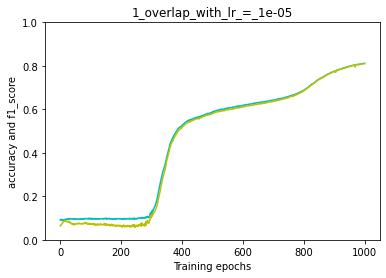

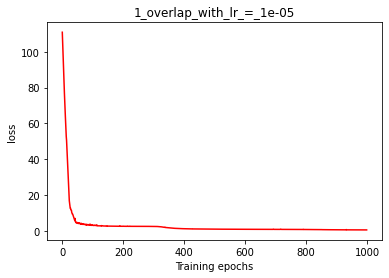

In [ ]:
common_num = 8
overlap_list = [1]
p_num = 2
#設定train幾個epochs
epochs = 1000

for overlap in overlap_list:
    #處理dataset
    print(f'Start splitting data')
    TrainData_dict, TestData_dict, ValidData_dict = Two_Party_SplitData(train_set, test_set, valid_set, common_num, overlap)
    print(f'End splitting data')
    #創立Party_A,Party_B,Server
    Party_A,Party_B,Server = GeneratePartyAndServer()

    train_loss, train_accuracy, train_f1 = [], [], []
    while len(train_f1) == 0 and len(train_accuracy) == 0 and len(train_f1) == 0:
        print(f'Start training data with overlap = {overlap}, common_num = {common_num}')
        train_loss, train_accuracy, train_f1 = similarities_explot_vertical_train(Party_A,Party_B,Server,TrainData_dict,epochs)
        print(f'End training data')
    # train_loss, train_accuracy, train_f1 = similarities_explot_vertical_train(Party_A,Party_B,Server,TestData_dict,epochs)
    test_loss, test_accuracy, test_f1 = vertical_test(Party_A,Party_B,Server,TestData_dict)
    test_loss, test_accuracy, test_f1 = vertical_test(Party_A,Party_B,Server,ValidData_dict)


    x_value = np.arange(0,len(train_loss),1)
    plt.plot(x_value,train_accuracy,color = 'c')
    plt.plot(x_value,train_f1,color = 'y')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.ylabel("accuracy and f1_score") # y label
    plt.xlabel("Training epochs") # x label
    s = str(overlap) + "_overlap_with_lr_=_" + str(args.lr)
    plt.title(s)
    f = s + "_accuracy_and_f1-score.png"
    plt.savefig(f"{f}")
    plt.show()

    plt.plot(x_value,train_loss,color = 'r')
    plt.ylabel("loss") # y label
    plt.xlabel("Training epochs") # x label
    s = str(overlap) + "_overlap_with_lr_=_" + str(args.lr)
    plt.title(s)
    f = s + "_loss.png"
    plt.savefig(f"{f}")
    plt.show()